In [1]:
True

True

In [2]:
# #%pip install clearml
    
# %env CLEARML_WEB_HOST=https://app.clear.ml/
# %env CLEARML_API_HOST=https://api.clear.ml
# %env CLEARML_FILES_HOST=https://files.clear.ml
# %env CLEARML_API_ACCESS_KEY=9H7BZE1POVNCNVARHSIOXBZNH2XQB5
# %env CLEARML_API_SECRET_KEY=TY1TLs7t-mmQTAnaCwX_aua9xrMrXoKbSmWDTrKEWHuOFrM4JPnni_JzHM9fm_qZXZk

In [3]:
import torch
torch.cuda.empty_cache()

#task.close()

In [4]:
from clearml import Task, Logger

task = Task.init(project_name='Imagenet debug', task_name='test')

ClearML Task: overwriting (reusing) task id=89d3a1722b2f41eba8961822c35187a9
2025-03-16 21:00:52,933 - clearml.Repository Detection - WARNING - Failed accessing the jupyter server(s): []
2025-03-16 21:00:52,973 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/13bed997dcfd41c08b58845d9ee663be/experiments/89d3a1722b2f41eba8961822c35187a9/output/log


In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.datasets as datasets
from torchvision.transforms import v2
from torch.utils import data 

import tqdm

In [6]:
import os

# 227 for Alexnet, otherwise 224
_img_size = 227

# 100 for tiny, 2 for debug
_num_classes = 100
acc_max = min(_num_classes, 5)

_batch_size = 4
accumulation_steps = 32 # virtual batch size = 128

_num_epochs = 50

_lr = 3e-3
_momentum = 0.9
_weight_decay = 1e-4

_lr_step_size = 20
_lr_gamma = 0.1

_num_workers = 0 #os.cpu_count()

_dropout = 0

config = {
    "num_classes": _num_classes,
    "batch_size": _batch_size,
    "accumulation_steps": accumulation_steps,
    "epochs": _num_epochs,
    "start_lr": _lr,
    "momentum": _momentum,
    "weight_decay": _weight_decay,
    "lr_step_size": _lr_step_size,
    "_lr_gamma": _lr_gamma,
    "_num_workers": _num_workers,
    "_dropout": _dropout,
}
task.connect(config)

{'num_classes': 100,
 'batch_size': 4,
 'accumulation_steps': 32,
 'epochs': 50,
 'start_lr': 0.003,
 'momentum': 0.9,
 'weight_decay': 0.0001,
 'lr_step_size': 20,
 '_lr_gamma': 0.1,
 '_num_workers': 0,
 '_dropout': 0}

In [7]:
import cv2
import matplotlib.pyplot as plt

def show_cv2_img(img, figsize=(4, 4)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

In [8]:
import os

torch.manual_seed(69)

In [9]:
train_dir = os.getcwd() + '\\data\\imagenet_debug\\train' #'imagenet_tiny'
val_dir = os.getcwd() + '\\data\\imagenet_debug\\val' #'imagenet_tiny'

#train_dir = "/home/jupyter/datasphere/datasets/imagenet_tiny/imagenet_tiny/train"
#val_dir = "/home/jupyter/datasphere/datasets/imagenet_tiny/imagenet_tiny/val"

train_dataset = datasets.ImageFolder(
    train_dir,
    v2.Compose(
        [
            v2.RandomResizedCrop((_img_size, _img_size)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
)

val_dataset = datasets.ImageFolder(
    val_dir,
    v2.Compose(
        [
            v2.Resize(256),
            v2.CenterCrop(_img_size),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
)

len(train_dataset), len(val_dataset)

(2600, 100)

200 0 torch.Size([3, 227, 227])
-1.8956583 2.500567


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8956583..2.500567].


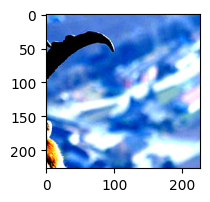

In [10]:
idx = 200 #np.random.randint(len(train_dataset))
img, label = train_dataset[idx]

np_img = img.numpy().transpose((1, 2, 0))

print(idx, label, img.shape)
print(np.amin(np_img), np.amax(np_img))

show_cv2_img(np_img, (2, 2))

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
train_loader = data.DataLoader(train_dataset, batch_size=_batch_size, num_workers=_num_workers, shuffle=True)  # , drop_last=True)
val_loader = data.DataLoader(val_dataset, batch_size=_batch_size, num_workers=_num_workers)

In [20]:
from models.alexnet import AlexNet
from models.vgg import Vgg
from models.resnet import ResNet18, ResNet50
from models.mobilenetV1 import MobileNet
from models.mobilenetV2 import MobileNetV2
from models.mobilenetV3 import MobileNetV3
from models.efficientnet import EfficientNet

torch.cuda.empty_cache()
#model = EfficientNet(_num_classes).to(device)
model = EfficientNet.from_name('efficientnet-b4', num_classes=_num_classes)

model

GlobalParams(width_coefficient=1.4, depth_coefficient=1.8, image_size=380, dropout_rate=0.4, num_classes=100, batch_norm_momentum=0.99, batch_norm_epsilon=0.001, drop_connect_rate=0.2, depth_divisor=8, min_depth=None, include_top=True)


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [21]:
inp = torch.rand((_batch_size, 3, _img_size, _img_size)).to(device)
model(inp).shape

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
def count_parameters(model):

    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        #print(f'{name}: {params}')

        total_params += params
        
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
ClearML Monitor: Reporting detected, reverting back to iteration based reporting


In [16]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 6.858MB


In [17]:
t = torch.cuda.get_device_properties(0).total_memory / 1024**2
r = torch.cuda.memory_reserved(0) / 1024**2 
a = torch.cuda.memory_allocated(0) / 1024**2

f = r - a # free inside reserved
f"Total: {t:.2f} mb, reserved: {r:.2f} mb, allocated: {a:.2f} mb, free inside reserved: {f:.2f} mb"

'Total: 4096.00 mb, reserved: 132.00 mb, allocated: 17.40 mb, free inside reserved: 114.60 mb'

In [22]:
# Specify the Loss function
criterion = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = optim.SGD(params=model.parameters(), lr=_lr, momentum=_momentum, weight_decay=_weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=_lr_step_size, gamma=_lr_gamma)

In [23]:
def train(model, train_loader):
    model.train()
    acc1 = []
    acc5 = []
    train_losses = []

    optimizer.zero_grad()  # why?

    for idx, (img_batch, label_batch) in enumerate(tqdm.tqdm(train_loader)):
        img_batch = img_batch.to(device)
        label_batch = label_batch.to(device)

        out = model(img_batch)
        loss = F.cross_entropy(out, label_batch)

        loss = loss / accumulation_steps  # Normalize the loss because it is accumulated
        loss.backward()  # Backward pass

        train_losses.append(loss.item())
        acc1.append(accuracy(out, label_batch))
        acc5.append(accuracy(out, label_batch, (acc_max,)))

        if (idx + 1) % accumulation_steps == 0:  # dataloader drop last # or (idx + 1) == len(train_loader):
            optimizer.step()  # Now we can do a optimizer step
            optimizer.zero_grad()  # zero the parameter gradients

    loss_avg = sum(train_losses) * accumulation_steps / len(train_losses)
    acc1_avg = sum(acc1) / len(acc1)
    acc5_avg = sum(acc5) / len(acc5)
    return loss_avg, acc1_avg, acc5_avg

In [24]:
def validation(model, val_loader):
    model.eval()
    val_losses = []
    acc1 = []
    acc5 = []
    with torch.inference_mode():
        for img_batch, label_batch in tqdm.tqdm(val_loader):
            img_batch = img_batch.to(device)
            label_batch = label_batch.to(device)

            out = model(img_batch)
            loss = criterion(out, label_batch)

            val_losses.append(loss.item())
            acc1.append(accuracy(out, label_batch))
            acc5.append(accuracy(out, label_batch, (acc_max,)))

    loss_avg = sum(val_losses) / len(val_losses)
    acc1_avg = sum(acc1) / len(acc1)
    acc5_avg = sum(acc5) / len(acc5)
    return loss_avg, acc1_avg, acc5_avg

In [25]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        results = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            results.append(correct_k.mul_(100.0 / batch_size))
        return results[0].item()

In [26]:
current_epoch = 1
min_loss = torch.inf

In [29]:
from datetime import datetime

logger = task.get_logger()

for epoch in range(current_epoch, current_epoch + _num_epochs):
    epoch_start = datetime.now()
    
    current_epoch = epoch
    print(f'Epoch: {epoch}')
    
    # train loop
    train_loss, train_acc1, train_acc5 = train(model, train_loader)
    print(f'Train loss: {train_loss:.4f}; acc: {train_acc1:.4f}')
    
    # val loop
    val_loss, val_acc1, val_acc5 = validation(model, val_loader)
    print(f'Val loss: {val_loss:.4f}; acc: {val_acc1:.4f}')
    
    # if val_loss < min_loss:
    #     min_loss = val_loss
    #     torch.save(model.state_dict(), f'./best_model.pth')
    
    logger.report_scalar("loss", 'train', iteration=epoch, value=train_loss)
    logger.report_scalar("loss", 'val', iteration=epoch, value=val_loss)
    logger.report_scalar("acc1", 'train', iteration=epoch, value=train_acc1)
    logger.report_scalar("acc1", 'val', iteration=epoch, value=val_acc1)
    logger.report_scalar(f"acc{acc_max}", 'train', iteration=epoch, value=train_acc5)
    logger.report_scalar(f"acc{acc_max}", 'val', iteration=epoch, value=val_acc5)
    
    
    cur_lr = [group['lr'] for group in optimizer.param_groups][0]
    scheduler.step()
    logger.report_scalar("lr", 'lr', iteration=epoch, value=cur_lr)
    #torch.save(model.state_dict(), f'./last_model.pth')
    
    print(f'epoch time: {datetime.now() - epoch_start}')
    print('-' * 10)

Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████| 650/650 [00:50<00:00, 12.76it/s]


Train loss: 0.6903; acc: 53.9231


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.96it/s]


Val loss: 0.6623; acc: 62.0000
epoch time: 0:00:53.288430
----------
Epoch: 2


 19%|███████████████                                                                 | 122/650 [00:08<00:35, 14.81it/s]


KeyboardInterrupt: 